In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
import itertools

def generate_normdist_X(dim,num_samples):
    mean=np.zeros(dim)
    cov=np.eye(dim)/np.sqrt(dim)
    X=np.random.default_rng().multivariate_normal(mean, cov, num_samples)
    return X

def generate_normdist_beta(dim):
    beta=np.random.default_rng().multivariate_normal(np.zeros(dim), np.eye(dim), 1)
    return beta

def make_sparse_beta(density,dim):
    beta=generate_normdist_beta(dim)
    dims_remove=np.concatenate([np.ones(int(round(density*dim))), np.zeros(int(round((1-density)*dim)))])
    sparse_beta=beta*dims_remove
    return sparse_beta

def generate_epsilon(num_samples,gamma,X,beta):
    sigma=np.sqrt(np.linalg.norm(np.matmul(X,beta.T))**2/(num_samples-1))/gamma
    epsilon=np.random.default_rng().multivariate_normal(np.zeros(num_samples), np.eye(num_samples)*sigma**2, 1)
    return epsilon

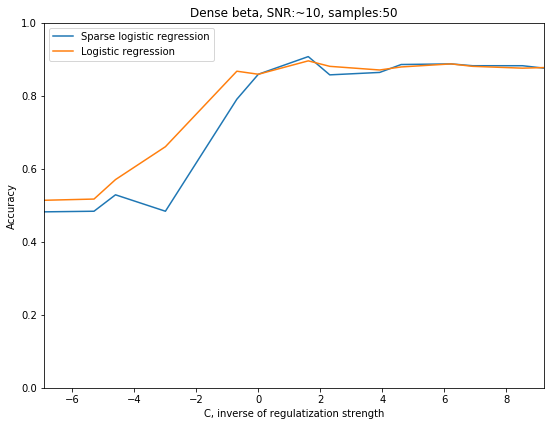

In [2]:
# Testing gamma dense beta

num_samples=50
dim=10
gamma=10
num_trials=50
C_vector=[1e-3,5e-3,1e-2, 5e-2, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]


score_l1=np.zeros(num_trials)
score_l2=np.zeros(num_trials)
avr_score_l1=np.zeros(len(C_vector))
avr_score_l2=np.zeros(len(C_vector))

for j in range(len(C_vector)):
    for i_trial in range(num_trials):
        X=generate_normdist_X(dim,num_samples)
        beta=generate_normdist_beta(dim)
        epsilon=generate_epsilon(num_samples,gamma,X,beta)
        SNR=np.linalg.norm(np.matmul(X,beta.T))/np.linalg.norm(epsilon)

        y=np.matmul(X,beta.T)+epsilon.T
        y_labels=np.sign(y)

        x_train=X[int(num_samples*0.25):]
        x_test=X[:int(num_samples*0.25)]
        y_train=y_labels[int(num_samples*0.25):].ravel()
        y_test=y_labels[:int(num_samples*0.25)]

        lr1=LogisticRegression(penalty='l1',solver='saga',max_iter=10000,C=C_vector[j])
        lr1.fit(x_train, y_train)
        score_l1[i_trial]=lr1.score(x_test,y_test)

        lr2=LogisticRegression(penalty='l2',C=C_vector[j])
        lr2.fit(x_train, y_train)
        score_l2[i_trial]=lr2.score(x_test,y_test)
    avr_score_l1[j]=np.mean(score_l1)
    avr_score_l2[j]=np.mean(score_l2)
    
    

plt.figure(figsize=(6.4*1.4, 4.8*1.4))
plt.plot(np.log(C_vector),avr_score_l1,label='Sparse logistic regression');
plt.plot(np.log(C_vector),avr_score_l2,label='Logistic regression');
plt.axis([np.log(1e-3),np.log(10000),0,1])
plt.legend(loc='upper left');
plt.title('Dense beta, SNR:' + '~' + str(gamma) + ', samples:'+str(num_samples));
plt.xlabel('C, inverse of regulatization strength')
plt.ylabel('Accuracy');

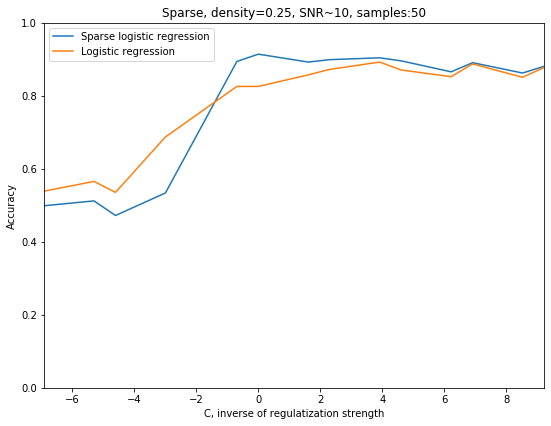

In [3]:
# Testing C sparse beta

num_samples=50
density=0.25
dim=10
gamma=10
num_trials=50
C_vector=[1e-3,5e-3,1e-2, 5e-2, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]


score_l1=np.zeros(num_trials)
score_l2=np.zeros(num_trials)
avr_score_l1=np.zeros(len(C_vector))
avr_score_l2=np.zeros(len(C_vector))

for j in range(len(C_vector)):
    for i_trial in range(num_trials):
        X=generate_normdist_X(dim,num_samples)
        beta=make_sparse_beta(density,dim)
        epsilon=generate_epsilon(num_samples,gamma,X,beta)
        SNR=np.linalg.norm(np.matmul(X,beta.T))/np.linalg.norm(epsilon)

        y=np.matmul(X,beta.T)+epsilon.T
        y_labels=np.sign(y)

        x_train=X[int(num_samples*0.25):]
        x_test=X[:int(num_samples*0.25)]
        y_train=y_labels[int(num_samples*0.25):].ravel()
        y_test=y_labels[:int(num_samples*0.25)]

        lr1=LogisticRegression(penalty='l1',solver='saga',max_iter=10000,C=C_vector[j])
        lr1.fit(x_train, y_train)
        score_l1[i_trial]=lr1.score(x_test,y_test)

        lr2=LogisticRegression(penalty='l2',C=C_vector[j])
        lr2.fit(x_train, y_train)
        score_l2[i_trial]=lr2.score(x_test,y_test)
    avr_score_l1[j]=np.mean(score_l1)
    avr_score_l2[j]=np.mean(score_l2)
    
    

plt.figure(figsize=(6.4*1.4, 4.8*1.4))
plt.plot(np.log(C_vector),avr_score_l1,label='Sparse logistic regression');
plt.plot(np.log(C_vector),avr_score_l2,label='Logistic regression');
plt.axis([np.log(1e-3),np.log(10000),0,1]);
plt.legend(loc='upper left');
plt.title('Sparse, density=' + str(density) + ', SNR' + '~' + str(gamma) + ', samples:'+str(num_samples));
plt.xlabel('C, inverse of regulatization strength');
plt.ylabel('Accuracy');

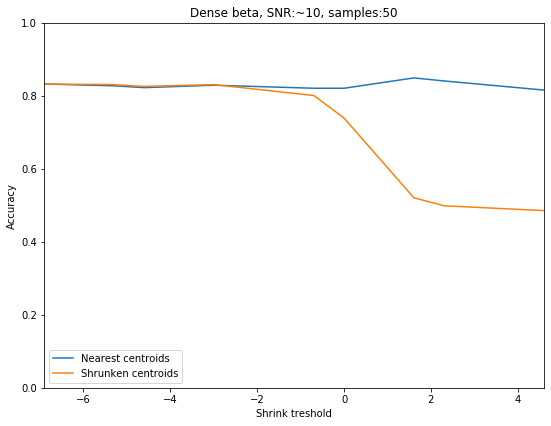

In [4]:
# Testing shrink_threshold dense beta

num_samples=50
dim=10
gamma=10
num_trials=50
shrink_threshold_vector=[1e-3, 5e-3, 1e-2, 5e-2, 0.5, 1, 5, 10, 100]

score_near_c=np.zeros(num_trials)
score_shrink_c=np.zeros(num_trials)
avr_score_near_c=np.zeros(len(shrink_threshold_vector))
avr_score_shrink_c=np.zeros(len(shrink_threshold_vector))

for j in range(len(shrink_threshold_vector)):
    for i_trial in range(num_trials):

        X=generate_normdist_X(dim,num_samples)
        beta=generate_normdist_beta(dim)
        epsilon=generate_epsilon(num_samples,gamma,X,beta)
        SNR=np.linalg.norm(np.matmul(X,beta.T))/np.linalg.norm(epsilon)

        y=np.matmul(X,beta.T)+epsilon.T
        y_labels=np.sign(y)

        x_train=X[int(num_samples*0.25):]
        x_test=X[:int(num_samples*0.25)]
        y_train=y_labels[int(num_samples*0.25):].ravel()
        y_test=y_labels[:int(num_samples*0.25)]


        near_c=NearestCentroid()
        near_c.fit(x_train, y_train)
        score_near_c[i_trial]=near_c.score(x_test,y_test)


        shrink_c=NearestCentroid(shrink_threshold=shrink_threshold_vector[j])
        shrink_c.fit(x_train, y_train)
        score_shrink_c[i_trial]=shrink_c.score(x_test,y_test)
    
    avr_score_near_c[j]=np.mean(score_near_c)
    avr_score_shrink_c[j]=np.mean(score_shrink_c)
    


plt.figure(figsize=(6.4*1.4, 4.8*1.4))
plt.plot(np.log(shrink_threshold_vector),avr_score_near_c,label='Nearest centroids');
plt.plot(np.log(shrink_threshold_vector),avr_score_shrink_c,label='Shrunken centroids');
plt.axis([np.log(1e-3),np.log(100),0,1])
plt.legend(loc='lower left');
plt.xlabel('Shrink treshold')
plt.ylabel('Accuracy')
plt.title('Dense beta, SNR:' + '~' + str(gamma) + ', samples:'+str(num_samples));

In [5]:
shrink_c.centroids_

array([[-0.02394049, -0.16850808,  0.17555777,  0.05677038,  0.09512704,
        -0.0849355 ,  0.04389598,  0.0319981 ,  0.02885572,  0.15038644],
       [-0.02394049, -0.16850808,  0.17555777,  0.05677038,  0.09512704,
        -0.0849355 ,  0.04389598,  0.0319981 ,  0.02885572,  0.15038644]])

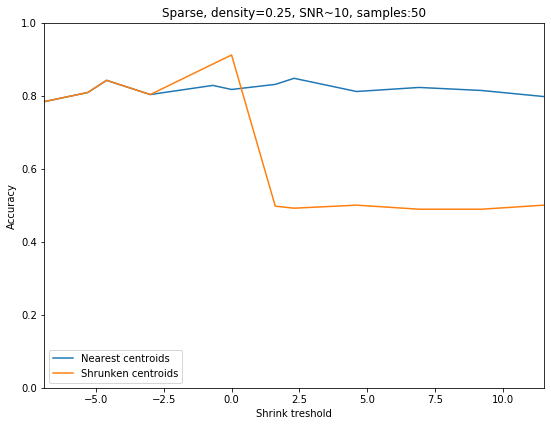

In [10]:
# Testing shrink_threshold sparse beta

num_samples=50
density=0.25
dim=10
gamma=10
num_trials=30
shrink_threshold_vector=[1e-3, 5e-3, 1e-2, 5e-2, 0.5, 1, 5, 10, 100,1000,10000,100000]



score_near_c=np.zeros(num_trials)
score_shrink_c=np.zeros(num_trials)
avr_score_near_c=np.zeros(len(shrink_threshold_vector))
avr_score_shrink_c=np.zeros(len(shrink_threshold_vector))

for j in range(len(shrink_threshold_vector)):
    for i_trial in range(num_trials):

        X=generate_normdist_X(dim,num_samples)
        beta=make_sparse_beta(density,dim)
        epsilon=generate_epsilon(num_samples,gamma,X,beta)
        SNR=np.linalg.norm(np.matmul(X,beta.T))/np.linalg.norm(epsilon)

        y=np.matmul(X,beta.T)+epsilon.T
        y_labels=np.sign(y)

        x_train=X[int(num_samples*0.25):]
        x_test=X[:int(num_samples*0.25)]
        y_train=y_labels[int(num_samples*0.25):].ravel()
        y_test=y_labels[:int(num_samples*0.25)]


        near_c=NearestCentroid()
        near_c.fit(x_train, y_train)
        score_near_c[i_trial]=near_c.score(x_test,y_test)


        shrink_c=NearestCentroid(shrink_threshold=shrink_threshold_vector[j])
        shrink_c.fit(x_train, y_train)
        score_shrink_c[i_trial]=shrink_c.score(x_test,y_test)
    
    avr_score_near_c[j]=np.mean(score_near_c)
    avr_score_shrink_c[j]=np.mean(score_shrink_c)
    


plt.figure(figsize=(6.4*1.4, 4.8*1.4))
plt.plot(np.log(shrink_threshold_vector),avr_score_near_c,label='Nearest centroids');
plt.plot(np.log(shrink_threshold_vector),avr_score_shrink_c,label='Shrunken centroids');
plt.axis([np.log(1e-3),np.log(100000),0,1])
plt.legend(loc='lower left');
plt.xlabel('Shrink treshold')
plt.ylabel('Accuracy');
plt.title('Sparse, density=' + str(density) + ', SNR' + '~' + str(gamma) + ', samples:'+str(num_samples));


In [7]:
shrink_c.centroids_

array([[-0.15810049,  0.07858679, -0.12534199, -0.11449861, -0.21914141,
         0.04699282, -0.11729789, -0.17702968, -0.01738114,  0.11698263],
       [-0.15810049,  0.07858679, -0.12534199, -0.11449861, -0.21914141,
         0.04699282, -0.11729789, -0.17702968, -0.01738114,  0.11698263]])